In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec30/train', transform=transform)
val_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec30/val', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec30/test', transform=transform)

/home/iai/anaconda3/envs/jwanaconda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

3201
1058
1058


In [3]:
import torch.nn as nn

# Define ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train(model, optimizer, criterion, labeled_loader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total = 0
    for images, labels in labeled_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(labeled_loader)
    train_acc /= total
    return train_loss, train_acc

In [4]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=4, verbose=False, delta=0, path='checkpoint.pt', min_epoch = 0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.epoch = 0
        self.min_epoch = min_epoch
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss
        self.epoch +=1
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            
            if self.epoch < self.min_epoch:
                self.counter = 0
                self.trace_func("Not enough epoch")
            else:
                self.counter += 1
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [5]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

val_acc_list_rand = []
val_loss_list_rand = []
val_recall_list_rand = []
val_precision_list_rand = []
val_f1_list_rand = []
val_auc_list_rand = []
val_fpr_list_rand = []
val_tpr_list_rand = []

num_initial_samples = 100
batch_size = 128

# Define initial labeled dataset
labeled_indices_rand = torch.randperm(len(train_dataset))[:num_initial_samples]
labeled_dataset_rand = torch.utils.data.Subset(train_dataset, labeled_indices_rand)

unlabeled_indices_rand = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices_rand).any(1)]
unlabeled_dataset_rand = torch.utils.data.Subset(train_dataset, unlabeled_indices_rand)

# Define data loaders
labeled_loader_rand = DataLoader(labeled_dataset_rand, batch_size=128, shuffle=True)
unlabeled_loader_rand = DataLoader(unlabeled_dataset_rand, batch_size=128, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


step = 1
# Active learning loop
while(len(unlabeled_dataset_rand) > 0):
    print("Step number:", step)

    model_rand = ResNet18(num_classes=30).to(device)
    early_stopping_rand = EarlyStopping(patience = 20, verbose = True, min_epoch = 0)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model_rand.parameters(), lr=0.001)

    for epoch in range(50):
        # Train model on labeled dataset
        train_loss, train_acc = train(model_rand, optimizer, criterion, labeled_loader_rand)
        print(f"Step : {step}, Epoch : {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")    

    # Evaluate model on val dataset
        model_rand.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            total = 0
            y_true = []
            y_pred = []
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_rand(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_acc += (predicted == labels).sum().item()
                y_true.extend(labels.tolist())
                y_pred.extend(predicted.tolist())
            val_loss /= len(val_loader)
            val_acc /= total

            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro')

            # Convert multi-class labels to binary labels (OVR)
            lb = LabelBinarizer()
            lb.fit(y_true)
            y_true_bin = lb.transform(y_true)
            y_pred_bin = lb.transform(y_pred)
            # Compute AUC score and ROC curve
            fpr, tpr, thresholds = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
            auc_score = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
            roc_auc = auc(fpr, tpr)
            
            # Early Stopping Condition
            early_stopping_rand(val_loss, model_rand)
            
            if early_stopping_rand.early_stop:
                val_auc_list_rand.append(auc_score)
                val_fpr_list_rand.append(fpr)
                val_tpr_list_rand.append(tpr)
                val_precision_list_rand.append(precision)
                val_recall_list_rand.append(recall)
                val_f1_list_rand.append(f1)
                val_acc_list_rand.append(val_acc)
                val_loss_list_rand.append(val_loss)
                print("Early stopping")
                print(f"Val Precision: {precision.item():.4f}, Val Recall: {recall.item():.4f}, Val F1 Score: {f1.item():.4f}")
                break
            
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")            
            
            if epoch == 49:
                val_auc_list_rand.append(auc_score)
                val_fpr_list_rand.append(fpr)
                val_tpr_list_rand.append(tpr)
                val_precision_list_rand.append(precision)
                val_recall_list_rand.append(recall)
                val_f1_list_rand.append(f1)
                val_acc_list_rand.append(val_acc)
                val_loss_list_rand.append(val_loss)
                print(f"Val Precision: {precision.item():.4f}, Val Recall: {recall.item():.4f}, Val F1 Score: {f1.item():.4f}")

        
            print(f"AUC Score: {auc_score:.4f}")
            print("")
            
        model_rand.load_state_dict(torch.load('checkpoint.pt'))

    # Iteration end condition
    if len(labeled_dataset_rand) > int(len(train_dataset)/2):
        break
    
    # Make model predictions on unlabeled dataset
    model_rand.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in unlabeled_loader_rand:
            images = images.to(device)
            output = model_rand(images)
            predictions.append(output)
    predictions = torch.cat(predictions, dim=0)

    # Select samples to label using entropy-based method
    entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    _, idx = torch.topk(entropy, k = 20) # select top 5

    labeled_indices_rand = torch.cat([labeled_indices_rand, unlabeled_indices_rand[idx]])
    unlabeled_indices_rand = unlabeled_indices_rand[~torch.eq(unlabeled_indices_rand.unsqueeze(1), unlabeled_indices_rand[idx]).any(1)]

    labeled_dataset_rand = torch.utils.data.Subset(train_dataset, labeled_indices_rand)
    unlabeled_dataset_rand = torch.utils.data.Subset(train_dataset, unlabeled_indices_rand)
    print("Updated Length of labeled dataset : ",len(labeled_dataset_rand))
    print("Length of unlabeled dataset : ",len(unlabeled_dataset_rand))
    print("-----------------------------------------------------------")

    # Update labeled and unlabeled data loaders
    labeled_loader_rand = DataLoader(labeled_dataset_rand, batch_size=batch_size, shuffle=True)
    unlabeled_loader_rand = DataLoader(unlabeled_dataset_rand, batch_size=batch_size, shuffle=True)

    step+=1

Step number: 1
Step : 1, Epoch : 1 - Train Loss: 3.6353, Train Accuracy: 0.0400
Validation loss decreased (inf --> 1.427607).  Saving model ...
Val Loss: 1.4276, Val Accuracy: 0.6957
AUC Score: 0.7386

Step : 1, Epoch : 2 - Train Loss: 0.9810, Train Accuracy: 0.8100
EarlyStopping counter: 1 out of 20
Val Loss: 1.4678, Val Accuracy: 0.6578
AUC Score: 0.7352

Step : 1, Epoch : 3 - Train Loss: 0.9810, Train Accuracy: 0.8100
EarlyStopping counter: 2 out of 20
Val Loss: 1.5823, Val Accuracy: 0.5756
AUC Score: 0.7342

Step : 1, Epoch : 4 - Train Loss: 0.9810, Train Accuracy: 0.8100
EarlyStopping counter: 3 out of 20
Val Loss: 1.6494, Val Accuracy: 0.5406
AUC Score: 0.7364

Step : 1, Epoch : 5 - Train Loss: 0.9810, Train Accuracy: 0.8100
EarlyStopping counter: 4 out of 20
Val Loss: 1.6928, Val Accuracy: 0.5340
AUC Score: 0.7392

Step : 1, Epoch : 6 - Train Loss: 0.9810, Train Accuracy: 0.8100
EarlyStopping counter: 5 out of 20
Val Loss: 1.7236, Val Accuracy: 0.5236
AUC Score: 0.7425

Step : 1

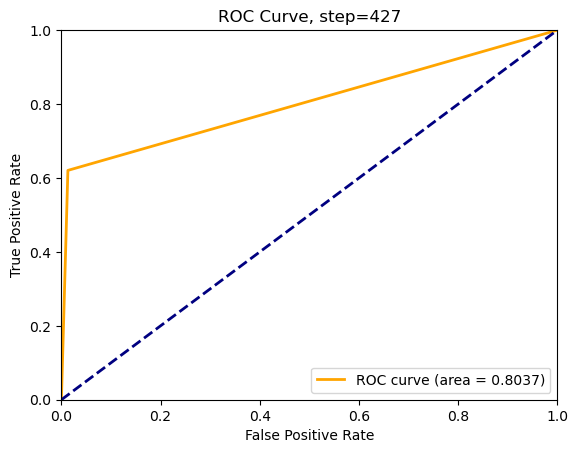

In [ ]:
# Evaluate model on Test Dataset


test_loss_rand = 0
test_acc_rand = 0
test_auc_score_rand = 0
test_roc_auc_rand = 0
test_precision_rand = 0
test_recall_rand = 0
test_f1_rand = 0

model_rand.eval()
with torch.no_grad():
    test_loss = 0.0
    test_acc = 0.0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_rand(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_acc += (predicted == labels).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    test_loss /= len(test_loader)
    test_acc /= total
    
    # Convert multi-class labels to binary labels (OVR)
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true_bin = lb.transform(y_true)
    y_pred_bin = lb.transform(y_pred)
    # Compute AUC score and ROC curve
    fpr, tpr, thresholds = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    test_auc_score_rand = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
    test_roc_auc_rand = auc(fpr, tpr)


    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"AUC Score: {test_auc_score_rand:.4f}")


    test_precision_rand, test_recall_rand, test_f1_rand, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro')

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

val_acc_list_unc = []
val_loss_list_unc = []
val_recall_list_unc = []
val_precision_list_unc = []
val_f1_list_unc = []
val_auc_list_unc = []
val_fpr_list_unc = []
val_tpr_list_unc = []

num_initial_samples = 100
batch_size = 128

# Define initial labeled dataset
labeled_indices_unc = torch.randperm(len(train_dataset))[:num_initial_samples]
labeled_dataset_unc = torch.utils.data.Subset(train_dataset, labeled_indices_unc)

unlabeled_indices_unc = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices_unc).any(1)]
unlabeled_dataset_unc = torch.utils.data.Subset(train_dataset, unlabeled_indices_unc)

# Define data loaders
labeled_loader_unc = DataLoader(labeled_dataset_unc, batch_size=128, shuffle=True)
unlabeled_loader_unc = DataLoader(unlabeled_dataset_unc, batch_size=128, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


step = 1
# Active learning loop
while(len(unlabeled_dataset_unc) > 0):
    print("Step number:", step)

    model_unc = ResNet18(num_classes=30).to(device)
    early_stopping_unc = EarlyStopping(patience = 20, verbose = True, min_epoch = 0)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model_unc.parameters(), lr=0.001)

    for epoch in range(50):
        # Train model on labeled dataset
        train_loss, train_acc = train(model_unc, optimizer, criterion, labeled_loader_unc)
        print(f"Step : {step}, Epoch : {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")    

    # Evaluate model on val dataset
        model_unc.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            total = 0
            y_true = []
            y_pred = []
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_unc(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_acc += (predicted == labels).sum().item()
                y_true.extend(labels.tolist())
                y_pred.extend(predicted.tolist())
            val_loss /= len(val_loader)
            val_acc /= total

            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro')

            # Convert multi-class labels to binary labels (OVR)
            lb = LabelBinarizer()
            lb.fit(y_true)
            y_true_bin = lb.transform(y_true)
            y_pred_bin = lb.transform(y_pred)
            # Compute AUC score and ROC curve
            fpr, tpr, thresholds = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
            auc_score = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
            roc_auc = auc(fpr, tpr)
            
            # Early Stopping Condition
            early_stopping_unc(val_loss, model_unc)
            
            if early_stopping_unc.early_stop:
                val_auc_list_unc.append(auc_score)
                val_fpr_list_unc.append(fpr)
                val_tpr_list_unc.append(tpr)
                val_precision_list_unc.append(precision)
                val_recall_list_unc.append(recall)
                val_f1_list_unc.append(f1)
                val_acc_list_unc.append(val_acc)
                val_loss_list_unc.append(val_loss)
                print("Early stopping")
                print(f"Val Precision: {precision.item():.4f}, Val Recall: {recall.item():.4f}, Val F1 Score: {f1.item():.4f}")
                break
            
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")            
            
            if epoch == 49:
                val_auc_list_unc.append(auc_score)
                val_fpr_list_unc.append(fpr)
                val_tpr_list_unc.append(tpr)
                val_precision_list_unc.append(precision)
                val_recall_list_unc.append(recall)
                val_f1_list_unc.append(f1)
                val_acc_list_unc.append(val_acc)
                val_loss_list_unc.append(val_loss)
                print(f"Val Precision: {precision.item():.4f}, Val Recall: {recall.item():.4f}, Val F1 Score: {f1.item():.4f}")

        
            print(f"AUC Score: {auc_score:.4f}")
            print("")
            
        model_unc.load_state_dict(torch.load('checkpoint.pt'))

    # Iteration end condition
    if len(labeled_dataset_unc) > int(len(train_dataset)/2):
        break
    
    # Make model predictions on unlabeled dataset
    model_unc.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in unlabeled_loader_unc:
            images = images.to(device)
            output = model_unc(images)
            predictions.append(output)
    predictions = torch.cat(predictions, dim=0)

    # Select samples to label using entropy-based method
    entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    _, idx = torch.topk(entropy, k = 20) # select top 5

    labeled_indices_unc = torch.cat([labeled_indices_unc, unlabeled_indices_unc[idx]])
    unlabeled_indices_unc = unlabeled_indices_unc[~torch.eq(unlabeled_indices_unc.unsqueeze(1), unlabeled_indices_unc[idx]).any(1)]

    labeled_dataset_unc = torch.utils.data.Subset(train_dataset, labeled_indices_unc)
    unlabeled_dataset_unc = torch.utils.data.Subset(train_dataset, unlabeled_indices_unc)
    print("Updated Length of labeled dataset : ",len(labeled_dataset_unc))
    print("Length of unlabeled dataset : ",len(unlabeled_dataset_unc))
    print("-----------------------------------------------------------")

    # Update labeled and unlabeled data loaders
    labeled_loader_unc = DataLoader(labeled_dataset_unc, batch_size=batch_size, shuffle=True)
    unlabeled_loader_unc = DataLoader(unlabeled_dataset_unc, batch_size=batch_size, shuffle=True)

    step+=1

In [ ]:
# Evaluate model on Test Dataset


test_loss_unc = 0
test_acc_unc = 0
test_auc_score_unc = 0
test_roc_auc_unc = 0
test_precision_unc = 0
test_recall_unc = 0
test_f1_unc = 0

model_unc.eval()
with torch.no_grad():
    test_loss = 0.0
    test_acc = 0.0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_unc(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_acc += (predicted == labels).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    test_loss /= len(test_loader)
    test_acc /= total
    
    # Convert multi-class labels to binary labels (OVR)
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true_bin = lb.transform(y_true)
    y_pred_bin = lb.transform(y_pred)
    # Compute AUC score and ROC curve
    fpr, tpr, thresholds = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    test_auc_score_unc = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
    test_roc_auc_unc = auc(fpr, tpr)


    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"AUC Score: {test_auc_score_unc:.4f}")


    test_precision_unc, test_recall_unc, test_f1_unc, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro')

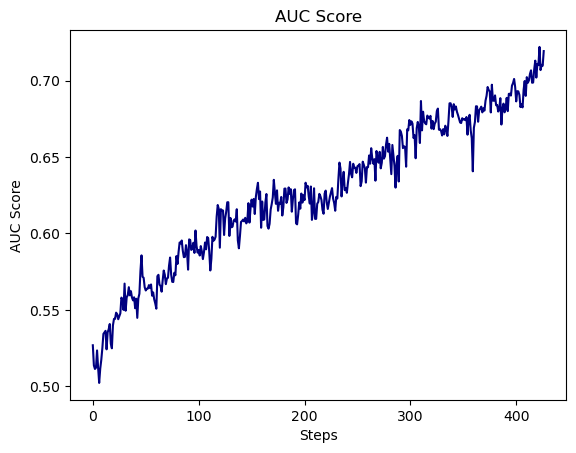

In [6]:
from matplotlib import pyplot as plt

plt.plot(test_auc_list, color = 'navy')
plt.xlabel("Steps")
plt.ylabel("AUC Score")
plt.title('AUC Score')
plt.show()